# MLP Scaling: $H$ vs $k$

Hidden neurons vs sequence length scaling experiments.

## Set up

In [14]:
# autoreload
%load_ext autoreload
%autoreload 2
# jupyter black formatter
%load_ext jupyter_black

import subprocess
import os
import sys

gitroot_path = subprocess.check_output(
    ["git", "rev-parse", "--show-toplevel"], universal_newlines=True
)

os.chdir(os.path.join(gitroot_path[:-1], "gagf"))
print("Working directory: ", os.getcwd())

sys_dir = os.path.dirname(os.getcwd())
sys.path.append(sys_dir)
print("Directory added to path: ", sys_dir)
sys.path.append(os.getcwd())
print("Directory added to path: ", os.getcwd())

import yaml
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black
Working directory:  /home/facosta/group-agf/gagf
Directory added to path:  /home/facosta/group-agf
Directory added to path:  /home/facosta/group-agf/gagf


## Specify experiment directory

In [15]:
sweep_dir = "/data/facosta/sweeps/sweep_mlp_scaling_20251212_161329"
os.path.exists(sweep_dir)

True

### Final Loss Heatmap

In [16]:
def load_sweep_results_grid(sweep_dir: str, k_values: list, hidden_dims: list):
    """
    Load sweep results and organize into a grid for heatmap visualization.

    Args:
        sweep_dir: Path to the sweep directory
        k_values: List of k (sequence length) values
        hidden_dims: List of hidden dimension values

    Returns:
        grid: 2D numpy array with shape (len(hidden_dims), len(k_values))
              containing mean final train losses
        std_grid: 2D numpy array with standard deviations (if multiple seeds)
    """
    sweep_path = Path(sweep_dir)

    # Initialize grids
    grid = np.full((len(hidden_dims), len(k_values)), np.nan)
    std_grid = np.full((len(hidden_dims), len(k_values)), np.nan)

    # Load results for each experiment
    for i, h in enumerate(hidden_dims):
        for j, k in enumerate(k_values):
            exp_name = f"k{k}_h{h}"
            exp_dir = sweep_path / exp_name

            if not exp_dir.exists():
                print(f"Warning: Experiment {exp_name} not found")
                continue

            # Load experiment summary
            summary_file = exp_dir / "experiment_summary.yaml"
            if summary_file.exists():
                with open(summary_file, "r") as f:
                    summary = yaml.safe_load(f)

                # Get mean train loss
                if "train_loss_stats" in summary:
                    grid[i, j] = summary["train_loss_stats"]["mean"]
                    std_grid[i, j] = summary["train_loss_stats"]["std"]
                else:
                    print(f"Warning: No train_loss_stats in {exp_name}")
            else:
                print(f"Warning: No summary file for {exp_name}")

    return grid, std_grid

In [17]:
k_values = [2, 3, 4, 5, 6, 7, 8]

# hidden_dims = [60, 360, 2160, 12960, 77760]
hidden_dims = [6, 6**2, 6**3, 6**4, 6**5, 6**6]

grid, _ = load_sweep_results_grid(sweep_dir, k_values, hidden_dims)

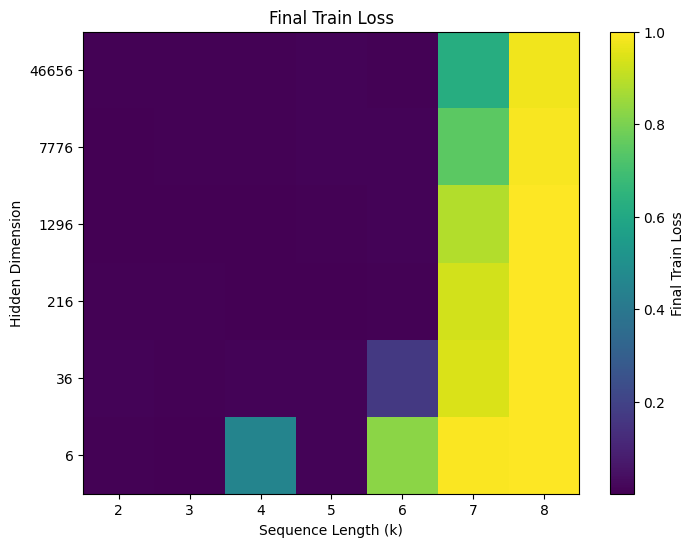

In [18]:
plt.figure(figsize=(8, 6))
plt.imshow(grid, aspect="auto", norm=None)

# Correct labels: rows = hidden_dims (y), columns = k_values (x)
plt.xlabel("Sequence Length (k)")
plt.ylabel("Hidden Dimension")

# Set tick labels to show actual values
plt.xticks(range(len(k_values)), k_values)
plt.yticks(range(len(hidden_dims)), hidden_dims)

plt.gca().invert_yaxis()

plt.title("Final Train Loss")

plt.colorbar(label="Final Train Loss")
plt.show()

### Loss Curve Integral Heatmap

In [19]:
def load_sweep_results_grid_integral(sweep_dir: str, k_values: list, hidden_dims: list):
    """
    Load sweep results and compute integral of loss curves.

    Returns:
        grid: 2D array with mean integral of loss curves
        std_grid: 2D array with standard deviations across seeds
    """
    sweep_path = Path(sweep_dir)

    grid = np.full((len(hidden_dims), len(k_values)), np.nan)
    std_grid = np.full((len(hidden_dims), len(k_values)), np.nan)

    for i, h in enumerate(hidden_dims):
        for j, k in enumerate(k_values):
            exp_name = f"k{k}_h{h}"
            exp_dir = sweep_path / exp_name

            if not exp_dir.exists():
                continue

            # Collect integrals from all seeds
            integrals = []
            for seed_dir in exp_dir.glob("seed_*"):
                loss_file = seed_dir / "train_loss_history.npy"
                if loss_file.exists():
                    loss_history = np.load(loss_file)
                    # Compute integral using trapezoidal rule
                    integral = np.trapz(loss_history)
                    integrals.append(integral)

            if integrals:
                grid[i, j] = np.mean(integrals)
                std_grid[i, j] = np.std(integrals) if len(integrals) > 1 else 0.0

    return grid, std_grid

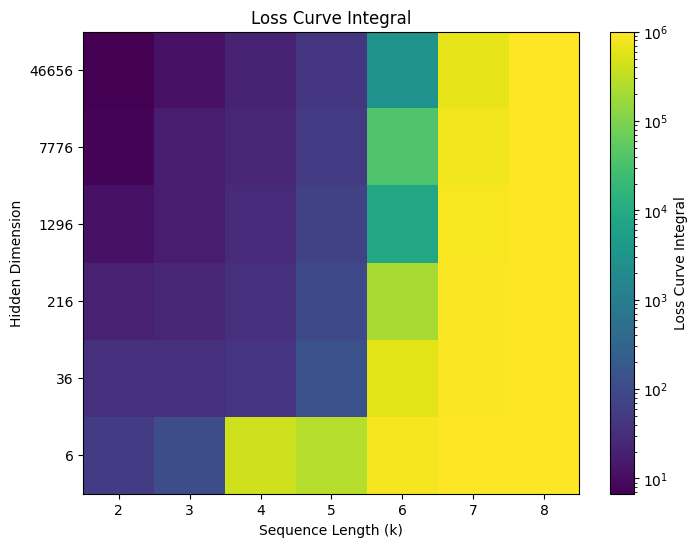

In [20]:
integral_grid, integral_std = load_sweep_results_grid_integral(
    sweep_dir, k_values, hidden_dims
)

from matplotlib.colors import LogNorm, SymLogNorm

plt.figure(figsize=(8, 6))
plt.imshow(integral_grid, aspect="auto", norm=LogNorm())
plt.xlabel("Sequence Length (k)")
plt.ylabel("Hidden Dimension")
plt.xticks(range(len(k_values)), k_values)
plt.yticks(range(len(hidden_dims)), hidden_dims)

plt.gca().invert_yaxis()
plt.colorbar(label="Loss Curve Integral")
plt.title("Loss Curve Integral")
plt.show()

### Steps to Convergence Heatmap

In [21]:
def load_sweep_results_grid_convergence(
    sweep_dir: str, k_values: list, hidden_dims: list, reduction_threshold: float = 0.99
):
    """
    Load sweep results and compute steps to convergence.

    Convergence is defined as reaching `reduction_threshold` loss reduction
    (e.g., 0.99 = 99% reduction from initial loss).

    If convergence is not reached, the grid point is set to NaN (blacked out).

    Args:
        sweep_dir: Path to the sweep directory
        k_values: List of k (sequence length) values
        hidden_dims: List of hidden dimension values
        reduction_threshold: Fraction of loss reduction to consider converged

    Returns:
        grid: 2D array with mean steps to convergence (NaN if didn't converge)
        std_grid: 2D array with standard deviations across seeds
    """
    sweep_path = Path(sweep_dir)

    grid = np.full((len(hidden_dims), len(k_values)), np.nan)
    std_grid = np.full((len(hidden_dims), len(k_values)), np.nan)

    for i, h in enumerate(hidden_dims):
        for j, k in enumerate(k_values):
            exp_name = f"k{k}_h{h}"
            exp_dir = sweep_path / exp_name

            if not exp_dir.exists():
                continue

            # Collect convergence steps from all seeds
            convergence_steps = []
            for seed_dir in exp_dir.glob("seed_*"):
                loss_file = seed_dir / "train_loss_history.npy"
                if loss_file.exists():
                    loss_history = np.load(loss_file)
                    initial_loss = loss_history[0]

                    if initial_loss > 0:
                        # Compute reduction at each step
                        reductions = 1 - loss_history / initial_loss

                        # Find first step where reduction >= threshold
                        converged_mask = reductions >= reduction_threshold
                        if np.any(converged_mask):
                            step = np.argmax(converged_mask)  # First True
                            convergence_steps.append(step)
                        # else: Never converged - don't add to list

            if convergence_steps:
                grid[i, j] = np.mean(convergence_steps)
                std_grid[i, j] = (
                    np.std(convergence_steps) if len(convergence_steps) > 1 else 0.0
                )
            # else: No seeds converged - grid[i,j] remains NaN (blacked out)

    return grid, std_grid

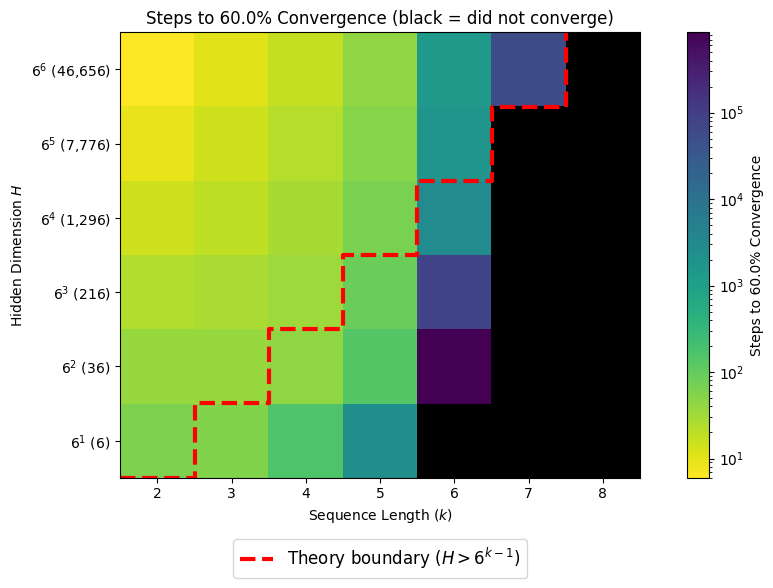

In [23]:
reduction_threshold = 0.6
conv_grid, conv_std = load_sweep_results_grid_convergence(
    sweep_dir, k_values, hidden_dims, reduction_threshold=reduction_threshold
)
plt.figure(figsize=(10, 6))  # Made slightly wider to accommodate legend
cmap = plt.cm.viridis_r.copy()
cmap.set_bad(color="black")
plt.imshow(conv_grid, aspect="equal", cmap=cmap, norm=LogNorm())

plt.xlabel("Sequence Length ($k$)")
plt.ylabel("Hidden Dimension $H$")
plt.xticks(range(len(k_values)), k_values)

# Create y-tick labels with both power notation and actual values
ytick_labels = [f"$6^{i+1}$ ({val:,})" for i, val in enumerate(hidden_dims)]
plt.yticks(range(len(hidden_dims)), ytick_labels)
plt.gca().invert_yaxis()

x_step = np.arange(len(k_values)) - 0.5
y_step = np.minimum(x_step, len(hidden_dims))  # Example: stays within bounds

plt.step(
    x_step,
    y_step,
    where="post",
    color="red",
    linewidth=3,
    linestyle="--",
    label="Theory boundary ($H > 6^{k-1}$)",
)

# Place legend outside the plot area (to the right)
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.12), fontsize=12, frameon=True)

plt.colorbar(label=f"Steps to {reduction_threshold*100}% Convergence")
plt.title(f"Steps to {reduction_threshold*100}% Convergence (black = did not converge)")
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()

In [24]:
def load_sweep_results_grid_spikiness(
    sweep_dir: str,
    k_values: list,
    hidden_dims: list,
):
    """
    Compute fraction of training steps where loss increased (instability).

    Returns:
        grid: 2D array with mean frac_upward across seeds
        std_grid: 2D array with standard deviations
    """
    sweep_path = Path(sweep_dir)

    grid = np.full((len(hidden_dims), len(k_values)), np.nan)
    std_grid = np.full((len(hidden_dims), len(k_values)), np.nan)

    for i, h in enumerate(hidden_dims):
        for j, k in enumerate(k_values):
            exp_name = f"k{k}_h{h}"
            exp_dir = sweep_path / exp_name

            if not exp_dir.exists():
                continue

            frac_upwards = []
            for seed_dir in exp_dir.glob("seed_*"):
                loss_file = seed_dir / "train_loss_history.npy"
                if loss_file.exists():
                    loss_history = np.load(loss_file)
                    log_loss = np.log10(loss_history + 1e-10)
                    log_changes = np.diff(log_loss)

                    # Fraction of steps where loss went UP
                    frac_upward = np.sum(log_changes > 0) / len(log_changes)
                    frac_upwards.append(frac_upward)

            if frac_upwards:
                grid[i, j] = np.mean(frac_upwards)
                std_grid[i, j] = np.std(frac_upwards) if len(frac_upwards) > 1 else 0.0

    return grid, std_grid

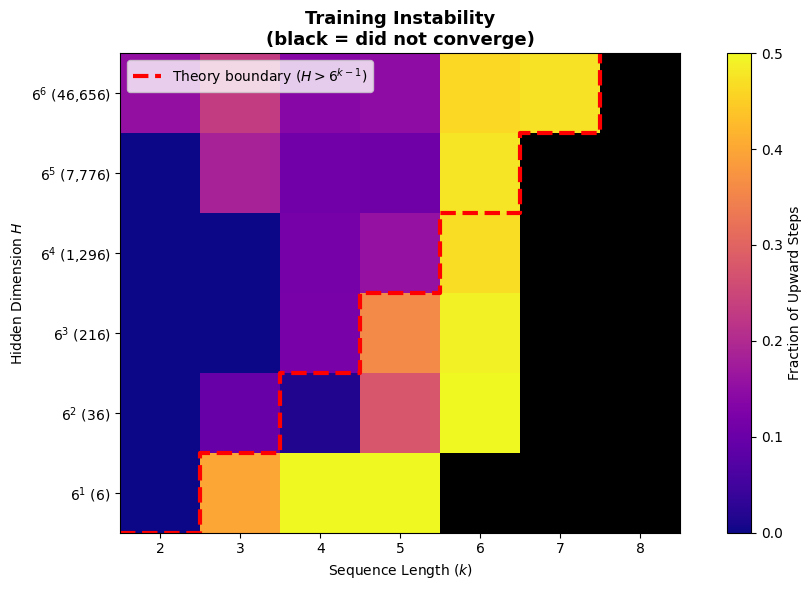


Converged runs: 30 (71.4%)
Did not converge (black): 12 (28.6%)



In [30]:
# Load both convergence and spikiness data
reduction_threshold = 0.6  # Adjust as needed
conv_grid, conv_std = load_sweep_results_grid_convergence(
    sweep_dir, k_values, hidden_dims, reduction_threshold=reduction_threshold
)

stability_grid, stability_std = load_sweep_results_grid_spikiness(
    sweep_dir, k_values, hidden_dims
)

# Create a masked version of stability_grid where non-converged runs are NaN
stability_grid_masked = stability_grid.copy()
stability_grid_masked[np.isnan(conv_grid)] = np.nan  # Mask non-converged runs

# Create plot
plt.figure(figsize=(10, 6))

# Use a colormap with bad values (NaN) shown as black
cmap = plt.cm.plasma.copy()
cmap.set_bad(color="black")

plt.imshow(stability_grid_masked, aspect="equal", cmap=cmap, vmin=0, vmax=0.5)

plt.xlabel("Sequence Length ($k$)")
plt.ylabel("Hidden Dimension $H$")
plt.xticks(range(len(k_values)), k_values)

# Create y-tick labels with both power notation and actual values
ytick_labels = [f"$6^{i+1}$ ({val:,})" for i, val in enumerate(hidden_dims)]
plt.yticks(range(len(hidden_dims)), ytick_labels)
plt.gca().invert_yaxis()

x_step = np.arange(len(k_values)) - 0.5
y_step = np.minimum(x_step, len(hidden_dims))  # Example: stays within bounds

plt.step(
    x_step,
    y_step,
    where="post",
    color="red",
    linewidth=3,
    linestyle="--",
    label="Theory boundary ($H > 6^{k-1}$)",
)

plt.legend(loc="upper left", fontsize=10, frameon=True)

plt.colorbar(label="Fraction of Upward Steps")
plt.title(
    f"Training Instability\n(black = did not converge)",
    fontsize=13,
    fontweight="bold",
)

plt.tight_layout()
plt.show()

# Print summary
n_converged = np.sum(~np.isnan(conv_grid))
n_not_converged = np.sum(np.isnan(conv_grid))
print(f"\n{'='*60}")
print(f"Converged runs: {n_converged} ({100*n_converged/conv_grid.size:.1f}%)")
print(
    f"Did not converge (black): {n_not_converged} ({100*n_not_converged/conv_grid.size:.1f}%)"
)
print(f"{'='*60}\n")

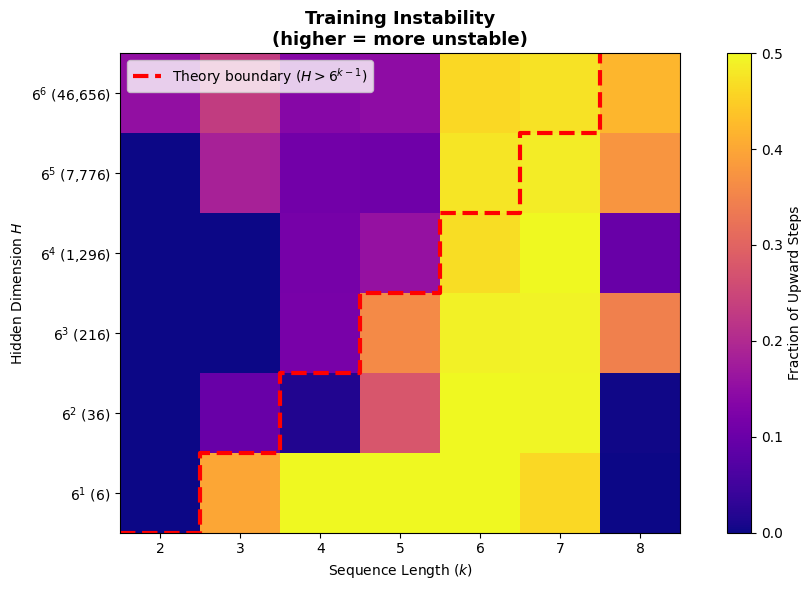

In [28]:
stability_grid, stability_std = load_sweep_results_grid_spikiness(
    sweep_dir, k_values, hidden_dims
)

# Create side-by-side subplots
plt.figure(figsize=(10, 6))

# ========== RIGHT PANEL: SPIKINESS ==========
# Use a different colormap - plasma, magma, or RdYlGn_r work well
plt.imshow(stability_grid, aspect="equal", cmap="plasma", vmin=0, vmax=0.5)


plt.xlabel("Sequence Length ($k$)")
plt.ylabel("Hidden Dimension $H$")
plt.xticks(range(len(k_values)), k_values)

# Create y-tick labels with both power notation and actual values
ytick_labels = [f"$6^{i+1}$ ({val:,})" for i, val in enumerate(hidden_dims)]
plt.yticks(range(len(hidden_dims)), ytick_labels)
plt.gca().invert_yaxis()

x_step = np.arange(len(k_values)) - 0.5
y_step = np.minimum(x_step, len(hidden_dims))  # Example: stays within bounds

plt.step(
    x_step,
    y_step,
    where="post",
    color="red",
    linewidth=3,
    linestyle="--",
    label="Theory boundary ($H > 6^{k-1}$)",
)

plt.legend(loc="upper left", fontsize=10, frameon=True)

plt.colorbar(label="Fraction of Upward Steps")
# cbar2.ax.axhline(0.3, color="white", linewidth=2, linestyle="--")  # Mark threshold
plt.title(
    "Training Instability\n(higher = more unstable)", fontsize=13, fontweight="bold"
)

plt.tight_layout()
plt.show()

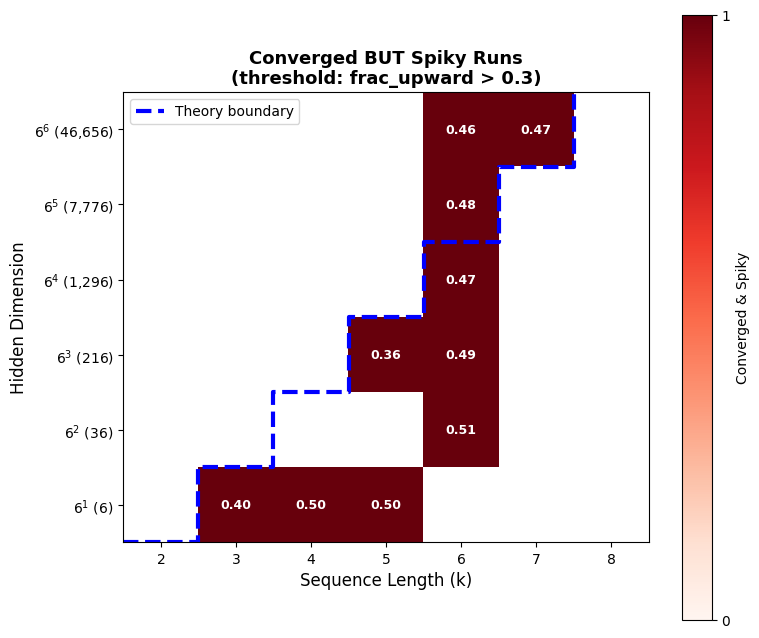


SUMMARY: Converged & Spiky Runs
Spikiness threshold: 0.3 (frac_upward)
Converged & spiky:   10
Total converged:     30
Percentage:          33.3%



In [118]:
# Load both metrics
reduction_threshold = 0.6
conv_grid, conv_std = load_sweep_results_grid_convergence(
    sweep_dir, k_values, hidden_dims, reduction_threshold=reduction_threshold
)
stability_grid, stability_std = load_sweep_results_grid_spikiness(
    sweep_dir, k_values, hidden_dims
)

# Create binary mask: 1 if converged AND spiky, 0 otherwise
spikiness_threshold = 0.3  # Adjust this threshold as needed

converged_and_spiky = np.zeros_like(conv_grid)
for i in range(len(hidden_dims)):
    for j in range(len(k_values)):
        converged = not np.isnan(conv_grid[i, j])
        spiky = stability_grid[i, j] > spikiness_threshold

        if converged and spiky:
            converged_and_spiky[i, j] = 1.0
        else:
            converged_and_spiky[i, j] = np.nan  # Will show as white

# Plot
plt.figure(figsize=(8, 6.5))

# Custom colormap: white for NaN, red for 1
cmap = plt.cm.Reds.copy()
cmap.set_bad(color="white")

im = plt.imshow(converged_and_spiky, aspect="equal", cmap=cmap, vmin=0, vmax=1)

plt.xlabel("Sequence Length (k)", fontsize=12)
plt.ylabel("Hidden Dimension", fontsize=12)
plt.xticks(range(len(k_values)), k_values)

ytick_labels = [f"$6^{i+1}$ ({val:,})" for i, val in enumerate(hidden_dims)]
plt.yticks(range(len(hidden_dims)), ytick_labels)
plt.gca().invert_yaxis()

# Add theory boundary
x_step = np.arange(len(k_values)) - 0.5
y_step = np.minimum(x_step, len(hidden_dims))
plt.step(
    x_step,
    y_step,
    where="post",
    color="blue",
    linewidth=3,
    linestyle="--",
    label="Theory boundary",
)
plt.legend(loc="upper left", fontsize=10, frameon=True)

# Add text annotations showing spikiness values in colored cells
for i in range(len(hidden_dims)):
    for j in range(len(k_values)):
        if converged_and_spiky[i, j] == 1.0:
            spikiness_val = stability_grid[i, j]
            plt.text(
                j,
                i,
                f"{spikiness_val:.2f}",
                ha="center",
                va="center",
                fontsize=9,
                color="white",
                fontweight="bold",
            )

plt.colorbar(im, label="Converged & Spiky", ticks=[0, 1])
plt.title(
    f"Converged BUT Spiky Runs\n(threshold: frac_upward > {spikiness_threshold})",
    fontsize=13,
    fontweight="bold",
)
plt.tight_layout()
plt.show()

# Print summary
n_converged_spiky = np.sum(converged_and_spiky == 1.0)
n_converged_total = np.sum(~np.isnan(conv_grid))
print(f"\n{'='*60}")
print(f"SUMMARY: Converged & Spiky Runs")
print(f"{'='*60}")
print(f"Spikiness threshold: {spikiness_threshold} (frac_upward)")
print(f"Converged & spiky:   {n_converged_spiky}")
print(f"Total converged:     {n_converged_total}")
print(f"Percentage:          {100*n_converged_spiky/n_converged_total:.1f}%")
print(f"{'='*60}\n")

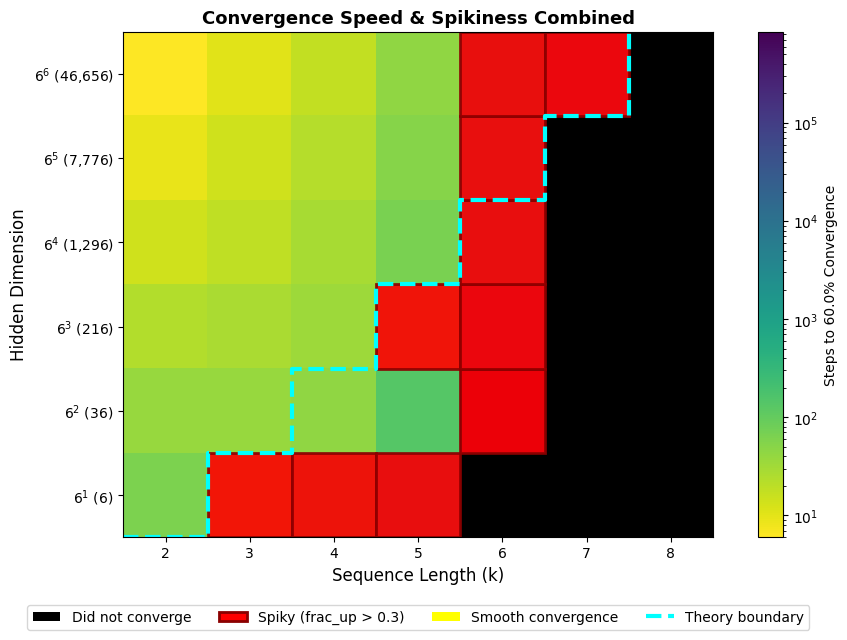


SUMMARY
Did not converge (black):  12 (28.6%)
Spiky converged (red):     10 (23.8%)
Smooth converged (color):  20 (47.6%)



In [125]:
# Load both metrics
reduction_threshold = 0.6
conv_grid, conv_std = load_sweep_results_grid_convergence(
    sweep_dir, k_values, hidden_dims, reduction_threshold=reduction_threshold
)
stability_grid, stability_std = load_sweep_results_grid_spikiness(
    sweep_dir, k_values, hidden_dims
)

# Parameters
spikiness_threshold = 0.3

# Create modified grid for plotting
# Strategy: Use a modified colormap and data array
plot_grid = conv_grid.copy()

# Create mask for spiky converged runs
spiky_mask = np.zeros_like(conv_grid, dtype=bool)
for i in range(len(hidden_dims)):
    for j in range(len(k_values)):
        converged = not np.isnan(conv_grid[i, j])
        spiky = stability_grid[i, j] > spikiness_threshold
        if converged and spiky:
            spiky_mask[i, j] = True

# Plot
fig, ax = plt.subplots(figsize=(10, 6.5))

# First: plot convergence grid with viridis_r (will handle black for NaN)
cmap_conv = plt.cm.viridis_r.copy()
cmap_conv.set_bad(color="black")
im = ax.imshow(plot_grid, aspect="equal", cmap=cmap_conv, norm=LogNorm())

# Second: overlay red patches for spiky converged runs
for i in range(len(hidden_dims)):
    for j in range(len(k_values)):
        if spiky_mask[i, j]:
            # Draw red square
            rect = plt.Rectangle(
                (j - 0.5, i - 0.5),
                1,
                1,
                facecolor="red",
                edgecolor="darkred",
                linewidth=2,
                alpha=0.9,
            )
            ax.add_patch(rect)

            # # Add convergence value in white text
            # conv_val = conv_grid[i, j]
            # ax.text(
            #     j,
            #     i,
            #     f"{int(conv_val)}",
            #     ha="center",
            #     va="center",
            #     fontsize=8,
            #     color="white",
            #     fontweight="bold",
            # )

# Formatting
ax.set_xlabel("Sequence Length (k)", fontsize=12)
ax.set_ylabel("Hidden Dimension", fontsize=12)
ax.set_xticks(range(len(k_values)))
ax.set_xticklabels(k_values)

ytick_labels = [f"$6^{i+1}$ ({val:,})" for i, val in enumerate(hidden_dims)]
ax.set_yticks(range(len(hidden_dims)))
ax.set_yticklabels(ytick_labels)
ax.invert_yaxis()

# Add theory boundary
x_step = np.arange(len(k_values)) - 0.5
y_step = np.minimum(x_step, len(hidden_dims))
ax.step(
    x_step,
    y_step,
    where="post",
    color="cyan",
    linewidth=3,
    linestyle="--",
    label="Theory boundary",
)

# Custom legend
from matplotlib.patches import Patch

legend_elements = [
    Patch(facecolor="black", label="Did not converge"),
    Patch(
        facecolor="red",
        edgecolor="darkred",
        linewidth=2,
        label=f"Spiky (frac_up > {spikiness_threshold})",
    ),
    Patch(facecolor="yellow", label="Smooth convergence"),
    plt.Line2D(
        [0], [0], color="cyan", linewidth=3, linestyle="--", label="Theory boundary"
    ),
]
ax.legend(
    handles=legend_elements,
    loc="upper center",
    bbox_to_anchor=(0.5, -0.12),
    fontsize=10,
    frameon=True,
    ncol=4,
)

plt.colorbar(im, ax=ax, label=f"Steps to {reduction_threshold*100}% Convergence")
ax.set_title("Convergence Speed & Spikiness Combined", fontsize=13, fontweight="bold")
plt.tight_layout()
plt.show()

# Print summary
n_not_converged = np.sum(np.isnan(conv_grid))
n_converged_spiky = np.sum(spiky_mask)
n_converged_smooth = np.sum(~np.isnan(conv_grid)) - n_converged_spiky
total = conv_grid.size

print(f"\n{'='*60}")
print(f"SUMMARY")
print(f"{'='*60}")
print(
    f"Did not converge (black): {n_not_converged:3d} ({100*n_not_converged/total:.1f}%)"
)
print(
    f"Spiky converged (red):    {n_converged_spiky:3d} ({100*n_converged_spiky/total:.1f}%)"
)
print(
    f"Smooth converged (color): {n_converged_smooth:3d} ({100*n_converged_smooth/total:.1f}%)"
)
print(f"{'='*60}\n")

### Curve plot: Convergence steps vs Sequence Length $k$ for different hidden dimensions
- x-axis: sequence length $k$
- y-axis: number of steps to convergence
- different curves for different hidden dimensions

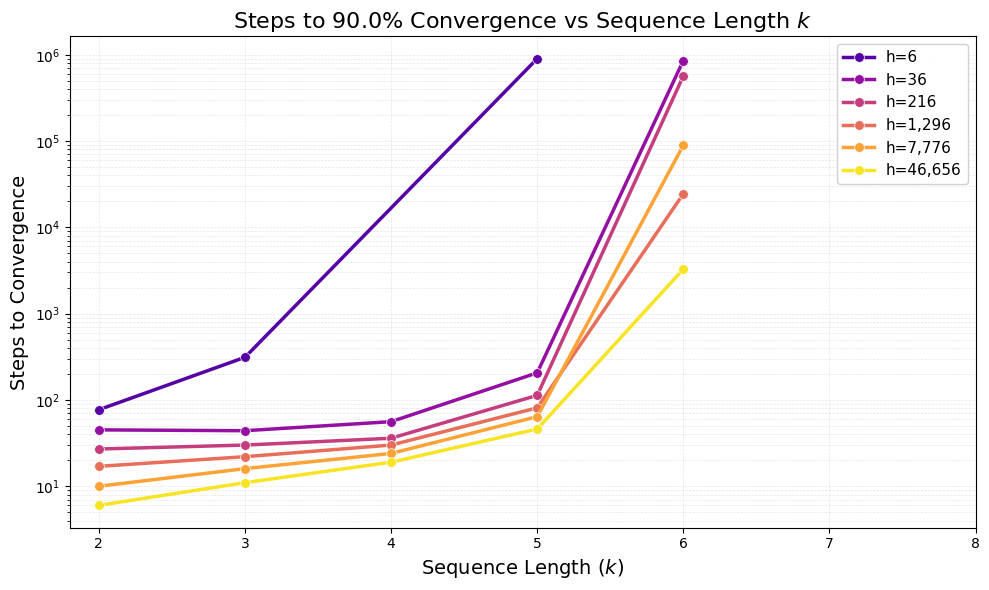

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Steps to 90.0% Convergence vs Sequence Length $k$'}, xlabel='Sequence Length ($k$)', ylabel='Steps to Convergence'>)

In [ ]:
def plot_convergence_vs_k(
    conv_grid,
    k_values,
    hidden_dims,
    save_path=None,
    show=True,
    log_x=True,
    log_y=True,
    reduction_threshold=0.9,
):
    """
    Plot steps to convergence vs sequence length k for different hidden dimensions.

    Args:
        conv_grid: 2D array (len(hidden_dims), len(k_values)) with convergence steps
        k_values: List of k (sequence length) values
        hidden_dims: List of hidden dimension values
        save_path: Where to save the plot
        show: Whether to display the plot
        log_x: Whether to use log scale for x-axis
        log_y: Whether to use log scale for y-axis
        reduction_threshold: Threshold used for convergence
    """
    fig, ax = plt.subplots(figsize=(10, 6))

    # Use a nice sequential colormap for different widths
    colors = plt.cm.plasma(np.linspace(0.15, 0.95, len(hidden_dims)))

    for i, (h, color) in enumerate(zip(hidden_dims, colors)):
        # Extract convergence steps for this hidden dim across all k values
        steps_for_h = conv_grid[i, :]

        # Only plot converged points
        converged_mask = ~np.isnan(steps_for_h)
        k_converged = np.array(k_values)[converged_mask]
        steps_converged = steps_for_h[converged_mask]

        if len(steps_converged) > 0:
            # Plot with line and markers
            ax.plot(
                k_converged,
                steps_converged,
                color=color,
                marker="o",
                markersize=7,
                linewidth=2.5,
                label=f"h={h:,}",
                markeredgewidth=0.5,
                markeredgecolor="white",
            )

    # Formatting
    ax.set_xlabel("Sequence Length ($k$)", fontsize=14)
    ax.set_ylabel("Steps to Convergence", fontsize=14)
    ax.set_title(
        f"Steps to {reduction_threshold*100}% Convergence vs Sequence Length $k$",
        fontsize=16,
    )
    if log_y:
        ax.set_yscale("log")
    if log_x:
        ax.set_xscale("log")
    ax.grid(True, alpha=0.3, which="both", linestyle="--", linewidth=0.5)
    ax.legend(fontsize=11, framealpha=0.9, loc="best")

    # Make k values discrete on x-axis
    ax.set_xticks(k_values)
    ax.set_xticklabels(k_values)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches="tight")
        print(f"Saved to {save_path}")

    if show:
        plt.show()
    else:
        plt.close()

    return fig, ax


reduction_threshold = 0.9
conv_grid, conv_std = load_sweep_results_grid_convergence(
    sweep_dir,
    k_values,
    hidden_dims,
    reduction_threshold=reduction_threshold,
)


plot_convergence_vs_k(
    conv_grid=conv_grid,
    k_values=k_values,
    hidden_dims=hidden_dims,
    save_path=None,
    show=True,
    log_x=False,
    log_y=True,
    reduction_threshold=reduction_threshold,
)

### Curve plot : Normalized Convergence Steps vs Sequence Length for different hidden dimensions
- x-axis: sequence length
- y-axis: normalized convergence steps ($\text{steps} / |G|^k$)
- different curves for different hidden dimensions $H$

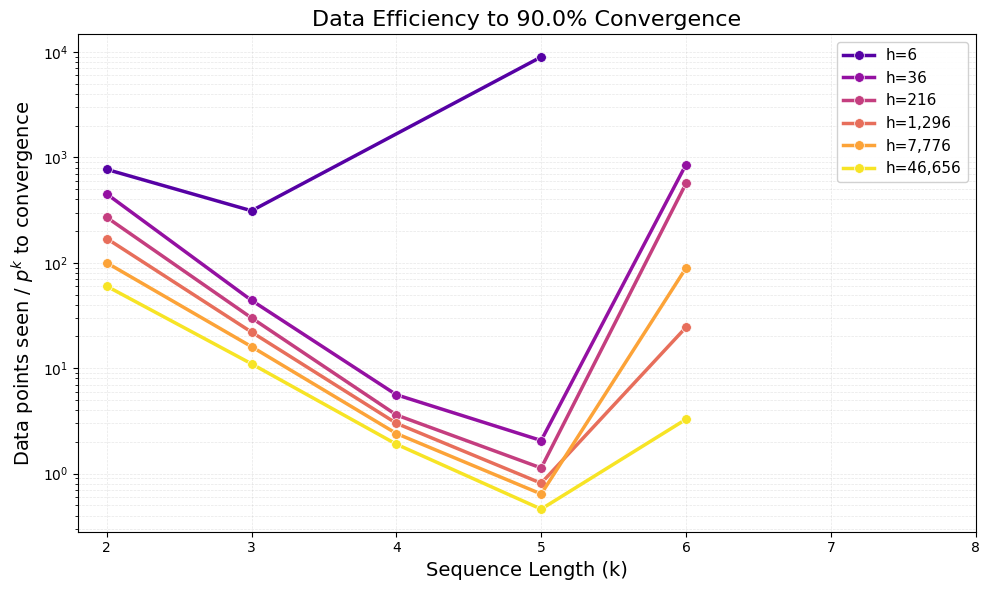

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Data Efficiency to 90.0% Convergence'}, xlabel='Sequence Length (k)', ylabel='Data points seen / $p^k$ to convergence'>)

In [140]:
def plot_convergence_vs_k_normalized(
    conv_grid,
    k_values,
    hidden_dims,
    p: int = 100,  # Vocabulary size
    batch_size: int = 1000,  # Batch size used in training
    save_path=None,
    show=True,
    log_x=False,
    log_y=True,
    reduction_threshold=0.9,
):
    """
    Plot fraction of data space seen to convergence vs sequence length k.

    Normalizes steps to convergence by the data space size (p^k) to show
    what fraction of the data space needs to be seen for convergence.

    Args:
        conv_grid: 2D array (len(hidden_dims), len(k_values)) with convergence steps
        k_values: List of k (sequence length) values
        hidden_dims: List of hidden dimension values
        p: Vocabulary size (data space per token)
        batch_size: Batch size used during training
        save_path: Where to save the plot
        show: Whether to display the plot
        log_x: Whether to use log scale for x-axis
        log_y: Whether to use log scale for y-axis
        reduction_threshold: Threshold used for convergence
    """
    fig, ax = plt.subplots(figsize=(10, 6))

    # Use a nice sequential colormap for different widths
    colors = plt.cm.plasma(np.linspace(0.15, 0.95, len(hidden_dims)))

    for i, (h, color) in enumerate(zip(hidden_dims, colors)):
        # Extract convergence steps for this hidden dim across all k values
        steps_for_h = conv_grid[i, :]

        # Only plot converged points
        converged_mask = ~np.isnan(steps_for_h)
        k_converged = np.array(k_values)[converged_mask]
        steps_converged = steps_for_h[converged_mask]

        if len(steps_converged) > 0:
            # Normalize by data space size for each k
            # samples_seen = steps * batch_size
            # fraction = samples_seen / p^k
            fractions = []
            for k_val, steps_val in zip(k_converged, steps_converged):
                data_space_size = p**k_val
                samples_seen = steps_val * batch_size
                fraction = samples_seen / data_space_size
                fractions.append(fraction)

            # Plot with line and markers
            ax.plot(
                k_converged,
                fractions,
                color=color,
                marker="o",
                markersize=7,
                linewidth=2.5,
                label=f"h={h:,}",
                markeredgewidth=0.5,
                markeredgecolor="white",
            )

    # Formatting
    ax.set_xlabel("Sequence Length (k)", fontsize=14)
    ax.set_ylabel("Data points seen / $p^k$ to convergence", fontsize=14)
    ax.set_title(
        f"Data Efficiency to {reduction_threshold*100}% Convergence",
        fontsize=16,
    )

    if log_y:
        ax.set_yscale("log")
    if log_x:
        ax.set_xscale("log")
    else:
        # Make k values discrete on x-axis
        ax.set_xticks(k_values)
        ax.set_xticklabels(k_values)

    ax.grid(True, alpha=0.3, which="both", linestyle="--", linewidth=0.5)
    ax.legend(fontsize=11, framealpha=0.9, loc="best")

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches="tight")
        print(f"Saved to {save_path}")

    if show:
        plt.show()
    else:
        plt.close()

    return fig, ax


reduction_threshold = 0.9
conv_grid, conv_std = load_sweep_results_grid_convergence(
    sweep_dir,
    k_values,
    hidden_dims,
    reduction_threshold=reduction_threshold,
)


plot_convergence_vs_k_normalized(
    conv_grid=conv_grid,
    k_values=k_values,
    hidden_dims=hidden_dims,
    p=10,  # Your vocabulary size
    batch_size=1000,  # Your batch size
    save_path=None,
    show=True,
    log_x=False,
    log_y=True,
    reduction_threshold=reduction_threshold,
)

### Curve plot: Loss vs Training Steps for different sequence lengths, fixed hidden dimension
- x-axis: # training steps
- y-axis: training loss
- different curves for different sequence lengths

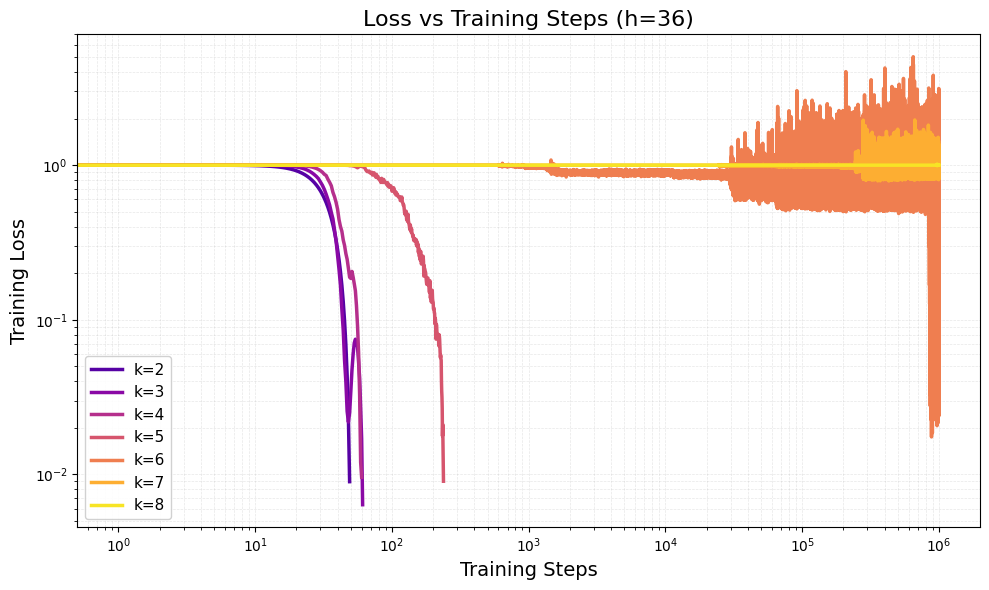

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Loss vs Training Steps (h=36)'}, xlabel='Training Steps', ylabel='Training Loss'>)

In [141]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path


def plot_loss_curves_fixed_width(
    sweep_dir: str,
    k_values: list,
    hidden_dim: int = 77760,
    seed: int = 0,
    save_path: str = None,
    show: bool = True,
    log_x: bool = True,
    log_y: bool = True,
):
    """
    Plot loss curves for different sequence lengths k with fixed hidden dimension.

    Args:
        sweep_dir: Path to sweep directory
        k_values: List of k values to plot (e.g., [2, 3, 4, 5, 6, 7, 8])
        hidden_dim: Fixed hidden dimension (default: 77760)
        seed: Which seed to plot (default: 0)
        save_path: Where to save the plot
        show: Whether to display the plot
        log_x: Whether to use log scale for x-axis
        log_y: Whether to use log scale for y-axis
    """
    sweep_path = Path(sweep_dir)

    # Create figure
    fig, ax = plt.subplots(figsize=(10, 6))

    # Use a nice sequential colormap (plasma, magma, cividis, YlOrRd, etc.)
    colors = plt.cm.plasma(
        np.linspace(0.15, 0.95, len(k_values))
    )  # Avoid too light/dark

    for k, color in zip(k_values, colors):
        run_dir = sweep_path / f"k{k}_h{hidden_dim}" / f"seed_{seed}"
        loss_file = run_dir / "train_loss_history.npy"

        if not loss_file.exists():
            print(f"Warning: No data found for k={k}, h={hidden_dim}")
            continue

        # Load loss history
        loss_history = np.load(loss_file)
        steps = np.arange(len(loss_history))

        # Plot
        ax.plot(steps, loss_history, color=color, lw=2.5, label=f"k={k}")

    # Formatting
    ax.set_xlabel("Training Steps", fontsize=14)
    ax.set_ylabel("Training Loss", fontsize=14)
    ax.set_title(f"Loss vs Training Steps (h={hidden_dim:,})", fontsize=16)
    if log_x:
        ax.set_xscale("log")
    if log_y:
        ax.set_yscale("log")
    ax.grid(True, alpha=0.3, which="both", linestyle="--", linewidth=0.5)
    ax.legend(fontsize=11, framealpha=0.9, loc="best")

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches="tight")
        print(f"Saved to {save_path}")

    if show:
        plt.show()
    else:
        plt.close()

    return fig, ax


plot_loss_curves_fixed_width(
    sweep_dir=sweep_dir,
    k_values=[2, 3, 4, 5, 6, 7, 8],
    hidden_dim=6**2,
    seed=0,
    save_path=None,
    show=True,
    log_x=True,
    log_y=True,
)

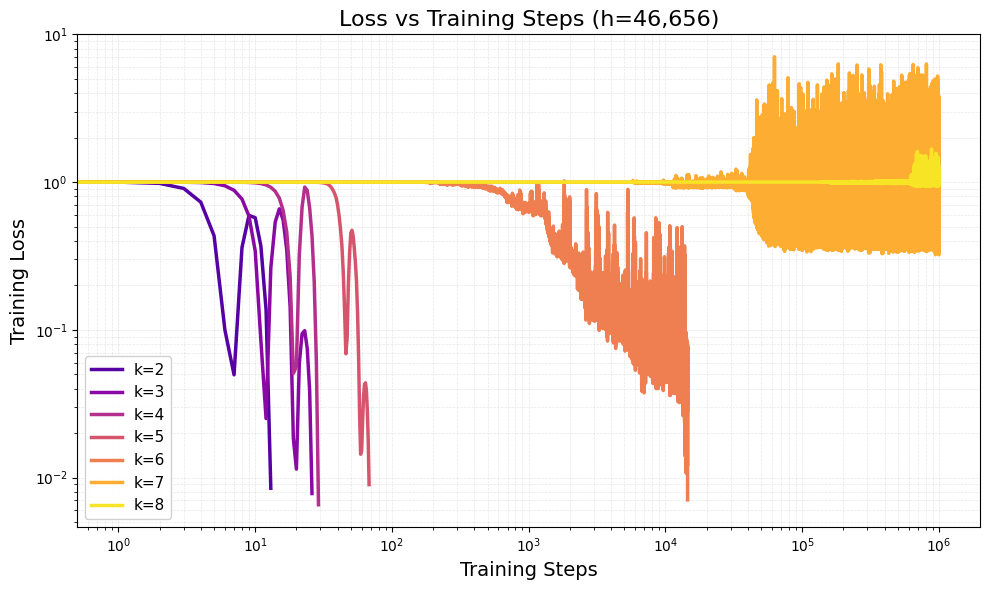


UPWARD SPIKE METRICS (h=46656)

Metric Definitions:
  frac_upward              : Fraction of steps where loss INCREASED
  upward_p95               : 95th percentile of upward jumps (instability)
  upward_p999              : 99.9th percentile of upward jumps
  upward_max               : Worst upward spike
  late_upward_p95          : 95th percentile of upward jumps in last 20%
  spike_to_progress_ratio  : Mean upward / mean downward (higher = more unstable)
  downward_p95             : 95th percentile of downward jumps (learning speed)

----------------------------------------------------------------------------------------------------
 k  n_steps  frac_upward  upward_p95  upward_p999  upward_max  late_upward_p95  spike_to_progress_ratio  downward_p95
 2       14       0.1538      0.8295       0.8610      0.8617           0.0000                   1.7123        0.9516
 3       27       0.2308      0.9435       1.0187      1.0202           0.6624                   1.6713        0.7162
 4

In [102]:
def compute_spikiness_metrics_upward_only(loss_history):
    """
    Compute spikiness focusing ONLY on upward jumps (loss increases).

    This separates:
    - Fast learning (large downward jumps) = STABLE
    - Instability (upward jumps) = UNSTABLE/SPIKY
    """
    log_loss = np.log10(loss_history + 1e-10)
    log_changes = np.diff(log_loss)  # Can be positive or negative

    # Separate upward (bad) from downward (good)
    upward_spikes = log_changes[log_changes > 0]  # Loss INCREASES
    downward_drops = log_changes[log_changes < 0]  # Loss DECREASES

    metrics = {}

    # Count how many steps are upward vs downward
    metrics["n_upward"] = len(upward_spikes)
    metrics["n_downward"] = len(downward_drops)
    metrics["frac_upward"] = (
        len(upward_spikes) / len(log_changes) if len(log_changes) > 0 else 0
    )

    if len(upward_spikes) > 0:
        # Metrics based ONLY on upward spikes (instability)
        metrics["upward_p95"] = np.percentile(upward_spikes, 95)
        metrics["upward_p999"] = np.percentile(upward_spikes, 99.9)
        metrics["upward_max"] = np.max(upward_spikes)
        metrics["upward_mean"] = np.mean(upward_spikes)
        metrics["upward_std"] = np.std(upward_spikes)
    else:
        # Perfectly monotonic decrease (never went up!)
        metrics["upward_p95"] = 0.0
        metrics["upward_p999"] = 0.0
        metrics["upward_max"] = 0.0
        metrics["upward_mean"] = 0.0
        metrics["upward_std"] = 0.0

    if len(downward_drops) > 0:
        # For reference: how fast is it learning?
        metrics["downward_p95"] = np.percentile(
            np.abs(downward_drops), 95
        )  # Large drops = fast
        metrics["downward_mean"] = np.mean(np.abs(downward_drops))
    else:
        metrics["downward_p95"] = 0.0
        metrics["downward_mean"] = 0.0

    # Ratio: upward spikes vs downward progress
    if metrics["downward_mean"] > 0:
        metrics["spike_to_progress_ratio"] = (
            metrics["upward_mean"] / metrics["downward_mean"]
        )
    else:
        metrics["spike_to_progress_ratio"] = (
            np.inf if metrics["upward_mean"] > 0 else 0.0
        )

    # Late-stage upward spikes (last 20%)
    cutoff = int(0.8 * len(log_changes))
    late_changes = log_changes[cutoff:]
    late_upward = late_changes[late_changes > 0]

    if len(late_upward) > 0:
        metrics["late_upward_p95"] = np.percentile(late_upward, 95)
        metrics["late_upward_max"] = np.max(late_upward)
    else:
        metrics["late_upward_p95"] = 0.0
        metrics["late_upward_max"] = 0.0

    return metrics


def plot_loss_curves_with_upward_metrics(
    sweep_dir: str,
    k_values: list,
    hidden_dim: int = 36,
    seed: int = 0,
    save_path: str = None,
    show: bool = True,
    log_x: bool = True,
    log_y: bool = True,
):
    """Plot loss curves with metrics focused on upward spikes only."""
    sweep_path = Path(sweep_dir)

    fig, ax = plt.subplots(figsize=(10, 6))
    colors = plt.cm.plasma(np.linspace(0.15, 0.95, len(k_values)))

    metrics_data = []

    for k, color in zip(k_values, colors):
        run_dir = sweep_path / f"k{k}_h{hidden_dim}" / f"seed_{seed}"
        loss_file = run_dir / "train_loss_history.npy"

        if not loss_file.exists():
            print(f"Warning: No data found for k={k}, h={hidden_dim}")
            continue

        loss_history = np.load(loss_file)
        steps = np.arange(len(loss_history))

        ax.plot(steps, loss_history, color=color, lw=2.5, label=f"k={k}")

        # Compute upward-only metrics
        metrics = compute_spikiness_metrics_upward_only(loss_history)
        metrics["k"] = k
        metrics["n_steps"] = len(loss_history)
        metrics_data.append(metrics)

    # Formatting
    ax.set_xlabel("Training Steps", fontsize=14)
    ax.set_ylabel("Training Loss", fontsize=14)
    ax.set_title(f"Loss vs Training Steps (h={hidden_dim:,})", fontsize=16)
    if log_x:
        ax.set_xscale("log")
    if log_y:
        ax.set_yscale("log")
    ax.grid(True, alpha=0.3, which="both", linestyle="--", linewidth=0.5)
    ax.legend(fontsize=11, framealpha=0.9, loc="best")

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches="tight")
        print(f"Saved to {save_path}")

    if show:
        plt.show()
    else:
        plt.close()

    # Print metrics
    df = pd.DataFrame(metrics_data)
    col_order = [
        "k",
        "n_steps",
        "frac_upward",
        "upward_p95",
        "upward_p999",
        "upward_max",
        "late_upward_p95",
        "spike_to_progress_ratio",
        "downward_p95",
    ]
    df = df[col_order]

    print("\n" + "=" * 100)
    print(f"UPWARD SPIKE METRICS (h={hidden_dim})")
    print("=" * 100)
    print("\nMetric Definitions:")
    print("  frac_upward              : Fraction of steps where loss INCREASED")
    print("  upward_p95               : 95th percentile of upward jumps (instability)")
    print("  upward_p999              : 99.9th percentile of upward jumps")
    print("  upward_max               : Worst upward spike")
    print("  late_upward_p95          : 95th percentile of upward jumps in last 20%")
    print(
        "  spike_to_progress_ratio  : Mean upward / mean downward (higher = more unstable)"
    )
    print(
        "  downward_p95             : 95th percentile of downward jumps (learning speed)"
    )
    print("\n" + "-" * 100)

    pd.set_option("display.max_columns", None)
    pd.set_option("display.width", None)
    pd.set_option("display.float_format", "{:.4f}".format)
    print(df.to_string(index=False))
    print("=" * 100 + "\n")

    return fig, ax, df


# Call it:
fig, ax, metrics_df = plot_loss_curves_with_upward_metrics(
    sweep_dir=sweep_dir,
    k_values=[2, 3, 4, 5, 6, 7, 8],
    hidden_dim=6**6,
    seed=0,
    save_path=None,
    show=True,
    log_x=True,
    log_y=True,
)

In [103]:
def load_sweep_results_grid_spikiness(
    sweep_dir: str,
    k_values: list,
    hidden_dims: list,
):
    """
    Compute fraction of training steps where loss increased (instability).

    Returns:
        grid: 2D array with mean frac_upward across seeds
        std_grid: 2D array with standard deviations
    """
    sweep_path = Path(sweep_dir)

    grid = np.full((len(hidden_dims), len(k_values)), np.nan)
    std_grid = np.full((len(hidden_dims), len(k_values)), np.nan)

    for i, h in enumerate(hidden_dims):
        for j, k in enumerate(k_values):
            exp_name = f"k{k}_h{h}"
            exp_dir = sweep_path / exp_name

            if not exp_dir.exists():
                continue

            frac_upwards = []
            for seed_dir in exp_dir.glob("seed_*"):
                loss_file = seed_dir / "train_loss_history.npy"
                if loss_file.exists():
                    loss_history = np.load(loss_file)
                    log_loss = np.log10(loss_history + 1e-10)
                    log_changes = np.diff(log_loss)

                    # Fraction of steps where loss went UP
                    frac_upward = np.sum(log_changes > 0) / len(log_changes)
                    frac_upwards.append(frac_upward)

            if frac_upwards:
                grid[i, j] = np.mean(frac_upwards)
                std_grid[i, j] = np.std(frac_upwards) if len(frac_upwards) > 1 else 0.0

    return grid, std_grid

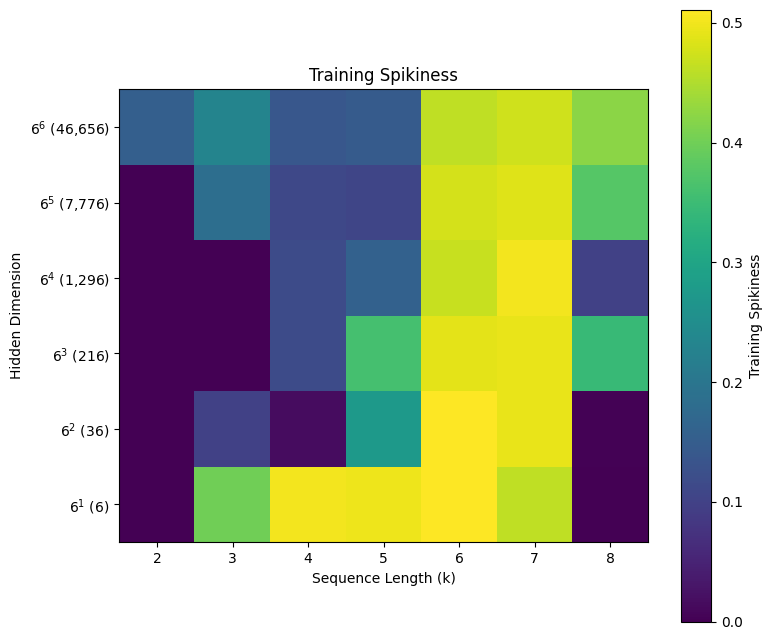

In [106]:
# Compute stability grid
stability_grid, stability_std = load_sweep_results_grid_spikiness(
    sweep_dir, k_values, hidden_dims
)

# Plot
plt.figure(figsize=(8, 6.5))
plt.imshow(stability_grid, aspect="equal", cmap="viridis")  # , norm=LogNorm())
plt.xlabel("Sequence Length (k)")
plt.ylabel("Hidden Dimension")
ytick_labels = [f"$6^{i+1}$ ({val:,})" for i, val in enumerate(hidden_dims)]
plt.yticks(range(len(hidden_dims)), ytick_labels)
plt.xticks(range(len(k_values)), k_values)
plt.gca().invert_yaxis()
plt.colorbar(label="Training Spikiness")
plt.title("Training Spikiness")
plt.tight_layout()
plt.show()

# Varying group size (num frequencies)

In [60]:
def load_sweep_results_grid_convergence_3d(
    sweep_dir: str,
    k_values: list,
    hidden_dims: list,
    num_frequencies: int,
    reduction_threshold: float = 0.99,
):
    """
    Load sweep results and compute steps to convergence for 3D sweeps over k, h, and f.

    This function is designed for sweeps that include num_frequencies as a parameter,
    using directory naming format: k{k}_h{h}_f{f}

    Convergence is defined as reaching `reduction_threshold` loss reduction
    (e.g., 0.99 = 99% reduction from initial loss).

    If convergence is not reached, the grid point is set to NaN (blacked out).

    Args:
        sweep_dir: Path to the sweep directory
        k_values: List of k (sequence length) values
        hidden_dims: List of hidden dimension values
        num_frequencies: Number of frequencies (f parameter)
        reduction_threshold: Fraction of loss reduction to consider converged

    Returns:
        grid: 2D array with mean steps to convergence (NaN if didn't converge)
        std_grid: 2D array with standard deviations across seeds
    """
    sweep_path = Path(sweep_dir)

    grid = np.full((len(hidden_dims), len(k_values)), np.nan)
    std_grid = np.full((len(hidden_dims), len(k_values)), np.nan)

    for i, h in enumerate(hidden_dims):
        for j, k in enumerate(k_values):
            exp_name = f"k{k}_h{h}_f{num_frequencies}"
            exp_dir = sweep_path / exp_name

            if not exp_dir.exists():
                continue

            # Collect convergence steps from all seeds
            convergence_steps = []
            for seed_dir in exp_dir.glob("seed_*"):
                loss_file = seed_dir / "train_loss_history.npy"
                if loss_file.exists():
                    loss_history = np.load(loss_file)
                    initial_loss = loss_history[0]

                    if initial_loss > 0:
                        # Compute reduction at each step
                        reductions = 1 - loss_history / initial_loss

                        # Find first step where reduction >= threshold
                        converged_mask = reductions >= reduction_threshold
                        if np.any(converged_mask):
                            step = np.argmax(converged_mask)  # First True
                            convergence_steps.append(step)
                        # else: Never converged - don't add to list

            if convergence_steps:
                grid[i, j] = np.mean(convergence_steps)
                std_grid[i, j] = (
                    np.std(convergence_steps) if len(convergence_steps) > 1 else 0.0
                )
            # else: No seeds converged - grid[i,j] remains NaN (blacked out)

    return grid, std_grid

## num_freq = 2

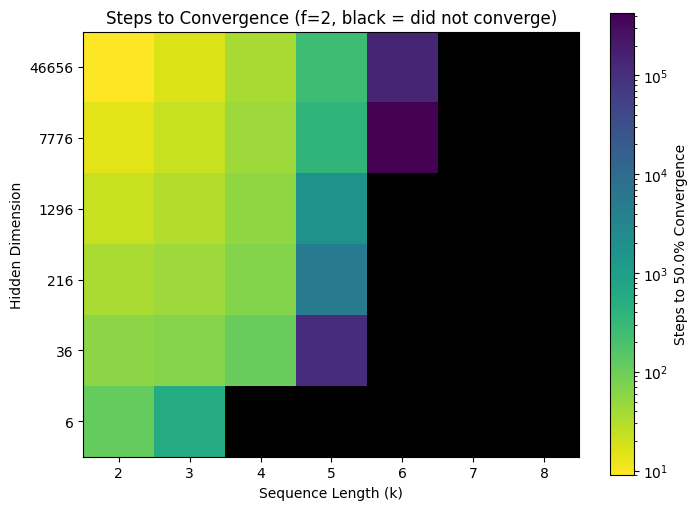

In [ ]:
# Example using the new 3D sweep (k, h, f)
new_sweep_dir = "/home/facosta/group-agf/sweeps/sweep_mlp_scaling_20251212_172318"

# Define parameter values for the new sweep
k_values_new = [2, 3, 4, 5, 6, 7, 8]
hidden_dims_new = [6, 36, 216, 1296, 7776, 46656]
num_frequencies = 2  # Set this to the frequency value you want to visualize

# Load convergence data for a specific frequency
reduction_threshold = 0.5
conv_grid_new, conv_std_new = load_sweep_results_grid_convergence_3d(
    new_sweep_dir,
    k_values_new,
    hidden_dims_new,
    reduction_threshold=reduction_threshold,
    num_frequencies=num_frequencies,
)

# Plot the heatmap
plt.figure(figsize=(8, 6))
cmap = plt.cm.viridis_r.copy()
cmap.set_bad(color="black")
plt.imshow(conv_grid_new, aspect="equal", cmap=cmap, norm=LogNorm())

plt.xlabel("Sequence Length (k)")
plt.ylabel("Hidden Dimension")
plt.xticks(range(len(k_values_new)), k_values_new)
plt.yticks(range(len(hidden_dims_new)), hidden_dims_new)
plt.gca().invert_yaxis()

plt.colorbar(label=f"Steps to {reduction_threshold*100}% Convergence")
plt.title(f"Steps to Convergence (f={num_frequencies}, black = did not converge)")
plt.show()

## num_freq = 3

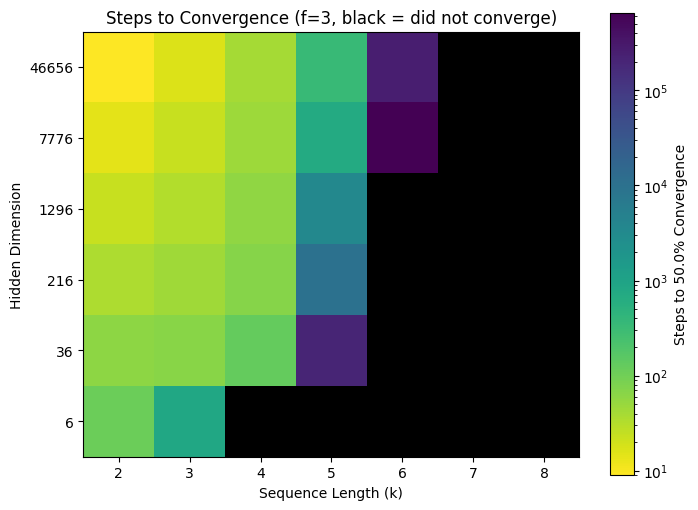

In [ ]:
# Example using the new 3D sweep (k, h, f)
new_sweep_dir = "/home/facosta/group-agf/sweeps/sweep_mlp_scaling_20251212_172318"

# Define parameter values for the new sweep
k_values_new = [2, 3, 4, 5, 6, 7, 8]
hidden_dims_new = [6, 36, 216, 1296, 7776, 46656]
num_frequencies = 3  # Set this to the frequency value you want to visualize

# Load convergence data for a specific frequency
reduction_threshold = 0.5
conv_grid_new, conv_std_new = load_sweep_results_grid_convergence_3d(
    new_sweep_dir,
    k_values_new,
    hidden_dims_new,
    reduction_threshold=reduction_threshold,
    num_frequencies=num_frequencies,
)

# Plot the heatmap
plt.figure(figsize=(8, 6))
cmap = plt.cm.viridis_r.copy()
cmap.set_bad(color="black")
plt.imshow(conv_grid_new, aspect="equal", cmap=cmap, norm=LogNorm())

plt.xlabel("Sequence Length (k)")
plt.ylabel("Hidden Dimension")
plt.xticks(range(len(k_values_new)), k_values_new)
plt.yticks(range(len(hidden_dims_new)), hidden_dims_new)
plt.gca().invert_yaxis()

plt.colorbar(label=f"Steps to {reduction_threshold*100}% Convergence")
plt.title(f"Steps to Convergence (f={num_frequencies}, black = did not converge)")
plt.show()

## num_freq = 4

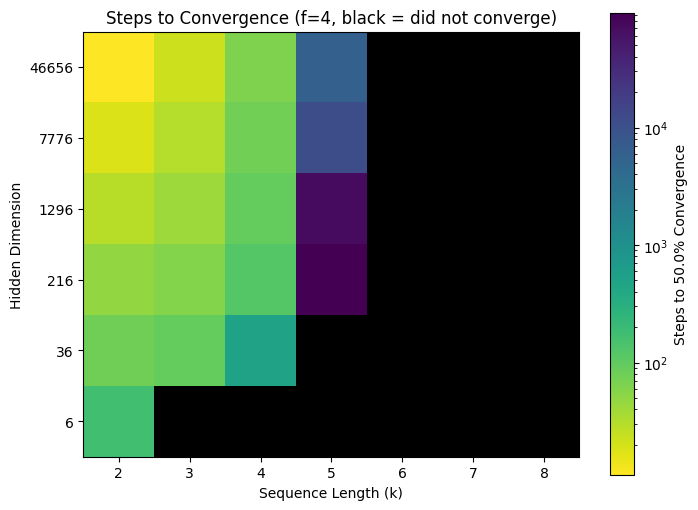

In [ ]:
# Example using the new 3D sweep (k, h, f)
new_sweep_dir = "/home/facosta/group-agf/sweeps/sweep_mlp_scaling_20251212_172318"

# Define parameter values for the new sweep
k_values_new = [2, 3, 4, 5, 6, 7, 8]
hidden_dims_new = [6, 36, 216, 1296, 7776, 46656]
num_frequencies = 4  # Set this to the frequency value you want to visualize

# Load convergence data for a specific frequency
reduction_threshold = 0.5
conv_grid_new, conv_std_new = load_sweep_results_grid_convergence_3d(
    new_sweep_dir,
    k_values_new,
    hidden_dims_new,
    reduction_threshold=reduction_threshold,
    num_frequencies=num_frequencies,
)

# Plot the heatmap
plt.figure(figsize=(8, 6))
cmap = plt.cm.viridis_r.copy()
cmap.set_bad(color="black")
plt.imshow(conv_grid_new, aspect="equal", cmap=cmap, norm=LogNorm())

plt.xlabel("Sequence Length (k)")
plt.ylabel("Hidden Dimension")
plt.xticks(range(len(k_values_new)), k_values_new)
plt.yticks(range(len(hidden_dims_new)), hidden_dims_new)
plt.gca().invert_yaxis()

plt.colorbar(label=f"Steps to {reduction_threshold*100}% Convergence")
plt.title(f"Steps to Convergence (f={num_frequencies}, black = did not converge)")
plt.show()

## num_freq = 5

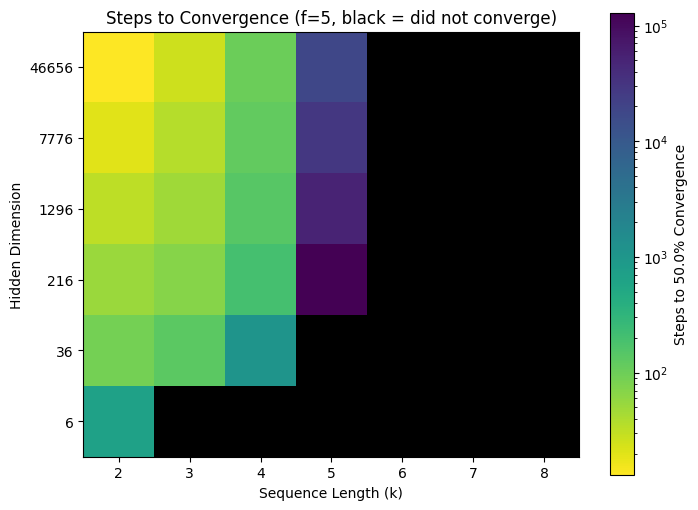

In [ ]:
# Example using the new 3D sweep (k, h, f)
new_sweep_dir = "/home/facosta/group-agf/sweeps/sweep_mlp_scaling_20251212_172318"

# Define parameter values for the new sweep
k_values_new = [2, 3, 4, 5, 6, 7, 8]
hidden_dims_new = [6, 36, 216, 1296, 7776, 46656]
num_frequencies = 5  # Set this to the frequency value you want to visualize

# Load convergence data for a specific frequency
reduction_threshold = 0.5
conv_grid_new, conv_std_new = load_sweep_results_grid_convergence_3d(
    new_sweep_dir,
    k_values_new,
    hidden_dims_new,
    reduction_threshold=reduction_threshold,
    num_frequencies=num_frequencies,
)

# Plot the heatmap
plt.figure(figsize=(8, 6))
cmap = plt.cm.viridis_r.copy()
cmap.set_bad(color="black")
plt.imshow(conv_grid_new, aspect="equal", cmap=cmap, norm=LogNorm())

plt.xlabel("Sequence Length (k)")
plt.ylabel("Hidden Dimension")
plt.xticks(range(len(k_values_new)), k_values_new)
plt.yticks(range(len(hidden_dims_new)), hidden_dims_new)
plt.gca().invert_yaxis()

plt.colorbar(label=f"Steps to {reduction_threshold*100}% Convergence")
plt.title(f"Steps to Convergence (f={num_frequencies}, black = did not converge)")
plt.show()

### Grid plot: Convergence vs k for different num_frequencies, across different hidden dimensions


In [65]:
def plot_convergence_vs_k_grid_by_frequency(
    sweep_dir: str,
    k_values: list,
    hidden_dims: list,
    num_frequencies_values: list,
    reduction_threshold: float = 0.99,
    figsize=(18, 12),
    log_x=False,
    log_y=True,
    save_path=None,
    show=True,
):
    """
    Create a grid of plots showing convergence vs k for different frequencies.

    Each subplot corresponds to a different hidden dimension.
    Within each subplot, different curves represent different num_frequencies values.

    Args:
        sweep_dir: Path to the sweep directory
        k_values: List of k (sequence length) values
        hidden_dims: List of hidden dimension values (one subplot per hidden dim)
        num_frequencies_values: List of num_frequencies values to compare
        reduction_threshold: Threshold for convergence definition
        figsize: Figure size tuple
        log_x: Whether to use log scale for x-axis
        log_y: Whether to use log scale for y-axis
        save_path: Where to save the plot
        show: Whether to display the plot

    Returns:
        fig, axes: Matplotlib figure and axes objects
    """
    sweep_path = Path(sweep_dir)

    # Determine grid layout (2x3 or 3x2 based on number of hidden dims)
    n_plots = len(hidden_dims)
    if n_plots == 6:
        nrows, ncols = 2, 3
    elif n_plots == 4:
        nrows, ncols = 2, 2
    else:
        # General case: aim for squarish layout
        ncols = int(np.ceil(np.sqrt(n_plots)))
        nrows = int(np.ceil(n_plots / ncols))

    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes_flat = axes.flatten() if n_plots > 1 else [axes]

    # Use a nice colormap for different frequencies
    colors = plt.cm.viridis(np.linspace(0.15, 0.85, len(num_frequencies_values)))

    for idx, h in enumerate(hidden_dims):
        ax = axes_flat[idx]

        # For each frequency, plot convergence vs k
        for f_idx, num_freq in enumerate(num_frequencies_values):
            convergence_steps_for_k = []
            k_values_converged = []

            for k in k_values:
                exp_name = f"k{k}_h{h}_f{num_freq}"
                exp_dir = sweep_path / exp_name

                if not exp_dir.exists():
                    continue

                # Collect convergence steps from all seeds
                convergence_steps = []
                for seed_dir in exp_dir.glob("seed_*"):
                    loss_file = seed_dir / "train_loss_history.npy"
                    if loss_file.exists():
                        loss_history = np.load(loss_file)
                        initial_loss = loss_history[0]

                        if initial_loss > 0:
                            reductions = 1 - loss_history / initial_loss
                            converged_mask = reductions >= reduction_threshold
                            if np.any(converged_mask):
                                step = np.argmax(converged_mask)
                                convergence_steps.append(step)

                # Take mean across seeds if any converged
                if convergence_steps:
                    k_values_converged.append(k)
                    convergence_steps_for_k.append(np.mean(convergence_steps))

            # Plot this frequency's curve
            if len(k_values_converged) > 0:
                ax.plot(
                    k_values_converged,
                    convergence_steps_for_k,
                    color=colors[f_idx],
                    marker="o",
                    markersize=6,
                    linewidth=2,
                    label=f"f={num_freq}",
                    markeredgewidth=0.5,
                    markeredgecolor="white",
                )

        # Formatting for this subplot
        ax.set_xlabel("Sequence Length (k)", fontsize=11)
        ax.set_ylabel("Steps to Convergence", fontsize=11)
        ax.set_title(f"h = {h:,}", fontsize=13, fontweight="bold")

        if log_y:
            ax.set_yscale("log")
        if log_x:
            ax.set_xscale("log")
        else:
            # Make k values discrete on x-axis
            ax.set_xticks(k_values)
            ax.set_xticklabels(k_values)

        ax.grid(True, alpha=0.3, which="both", linestyle="--", linewidth=0.5)
        ax.legend(fontsize=9, framealpha=0.9, loc="best")

    # Hide any unused subplots
    for idx in range(n_plots, len(axes_flat)):
        axes_flat[idx].axis("off")

    # Overall title
    fig.suptitle(
        f"Convergence vs Sequence Length by Number of Frequencies\n"
        f"({reduction_threshold*100:.0f}% Loss Reduction Threshold)",
        fontsize=16,
        fontweight="bold",
        y=0.995,
    )

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches="tight")
        print(f"Saved to {save_path}")

    if show:
        plt.show()
    else:
        plt.close()

    return fig, axes

Saved to convergence_vs_k_by_frequency_grid.pdf


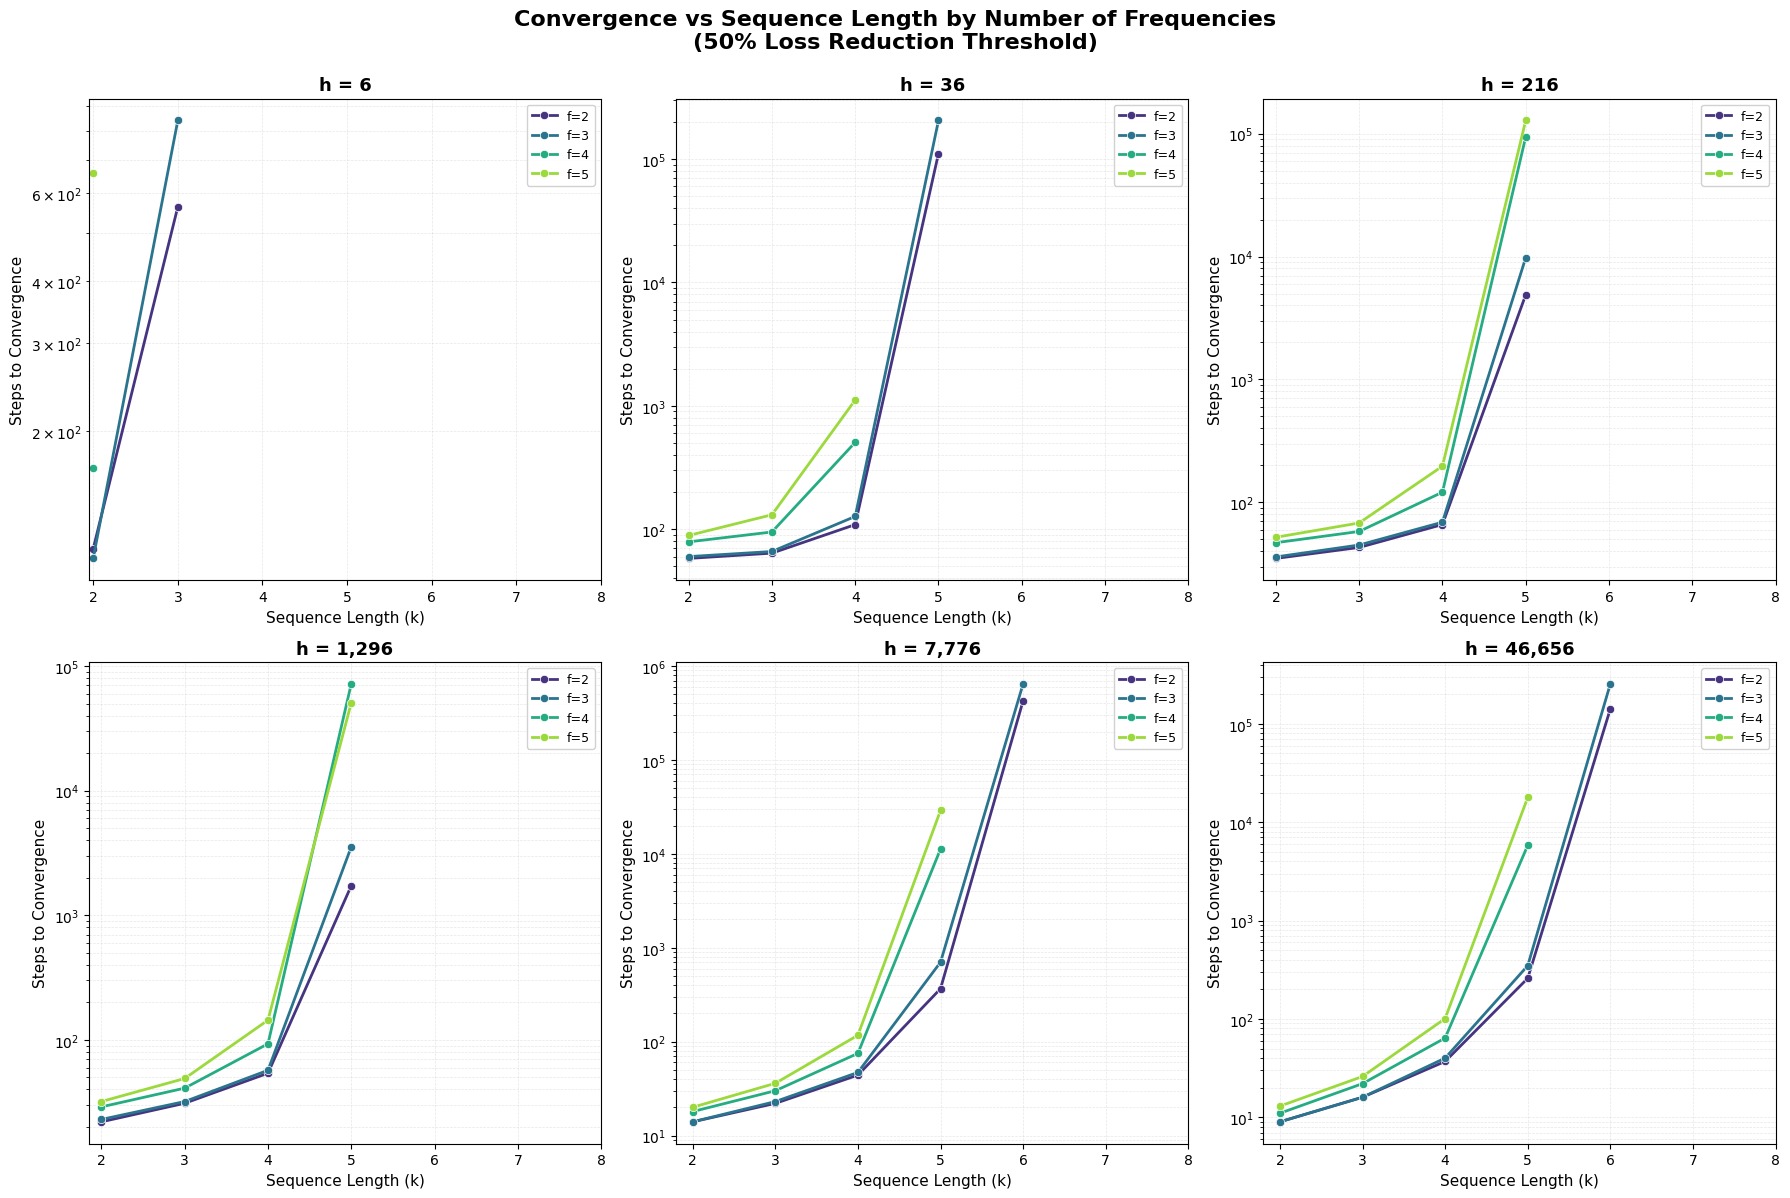

(<Figure size 1800x1200 with 6 Axes>,
 array([[<Axes: title={'center': 'h = 6'}, xlabel='Sequence Length (k)', ylabel='Steps to Convergence'>,
         <Axes: title={'center': 'h = 36'}, xlabel='Sequence Length (k)', ylabel='Steps to Convergence'>,
         <Axes: title={'center': 'h = 216'}, xlabel='Sequence Length (k)', ylabel='Steps to Convergence'>],
        [<Axes: title={'center': 'h = 1,296'}, xlabel='Sequence Length (k)', ylabel='Steps to Convergence'>,
         <Axes: title={'center': 'h = 7,776'}, xlabel='Sequence Length (k)', ylabel='Steps to Convergence'>,
         <Axes: title={'center': 'h = 46,656'}, xlabel='Sequence Length (k)', ylabel='Steps to Convergence'>]],
       dtype=object))

In [66]:
# Example usage: Create grid plot
new_sweep_dir = "/home/facosta/group-agf/sweeps/sweep_mlp_scaling_20251212_172318"

k_values_new = [2, 3, 4, 5, 6, 7, 8]
hidden_dims_new = [6, 36, 216, 1296, 7776, 46656]
num_frequencies_values = [2, 3, 4, 5]  # All frequency values to compare

plot_convergence_vs_k_grid_by_frequency(
    sweep_dir=new_sweep_dir,
    k_values=k_values_new,
    hidden_dims=hidden_dims_new,
    num_frequencies_values=num_frequencies_values,
    reduction_threshold=0.5,
    figsize=(18, 12),
    log_x=False,
    log_y=True,
    save_path=None,
    show=True,
)

## p=2 experiments

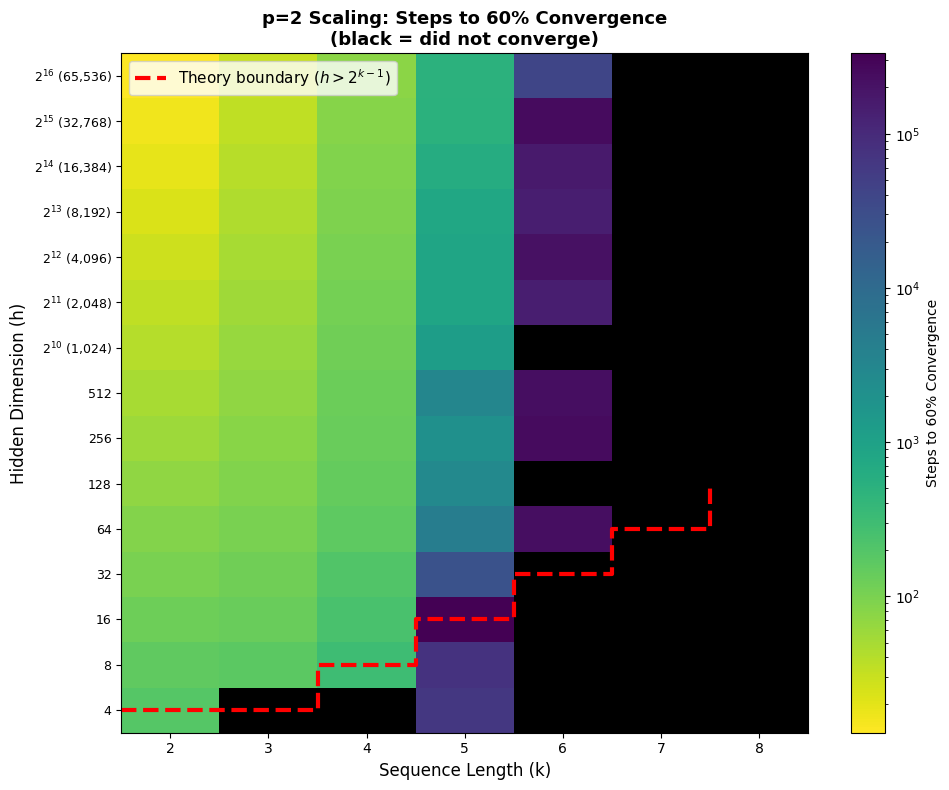


CONVERGENCE SUMMARY (p=2 scaling)
Converged:          67 (63.8%)
Did not converge:   38 (36.2%)
Total experiments: 105



In [6]:
# Define sweep directory and parameters
sweep_dir = "/home/facosta/group-agf/sweeps/p2_scaling_sweep_20251215_205347"

# Parameters from p2_scaling_sweep.yaml
k_values = [2, 3, 4, 5, 6, 7, 8]
hidden_dims = [
    4,
    8,
    16,
    32,
    64,
    128,
    256,
    512,
    1024,
    2048,
    4096,
    8192,
    16384,
    32768,
    65536,
]

# Load convergence data
reduction_threshold = 0.6  # 90% loss reduction
conv_grid, conv_std = load_sweep_results_grid_convergence(
    sweep_dir, k_values, hidden_dims, reduction_threshold=reduction_threshold
)


from matplotlib.colors import LogNorm

# Plot the heatmap
plt.figure(figsize=(10, 8))
cmap = plt.cm.viridis_r.copy()
cmap.set_bad(color="black")
plt.imshow(conv_grid, aspect="auto", cmap=cmap, norm=LogNorm())

plt.xlabel("Sequence Length (k)", fontsize=12)
plt.ylabel("Hidden Dimension (h)", fontsize=12)
plt.xticks(range(len(k_values)), k_values)

# Create y-tick labels with both power notation and actual values for larger dims
ytick_labels = []
for h in hidden_dims:
    if h >= 1024:
        power = int(np.log2(h))
        ytick_labels.append(f"$2^{{{power}}}$ ({h:,})")
    else:
        ytick_labels.append(f"{h}")

plt.yticks(range(len(hidden_dims)), ytick_labels, fontsize=9)
plt.gca().invert_yaxis()

# Add theoretical boundary line (h > p^(k-1), where p=2)
# For p=2: boundary at h = 2^(k-1), so h=1,2,4,8,16,32,64
x_step = np.arange(len(k_values)) - 0.5
# Find y index where h = 2^(k-1) for each k
y_boundary = []
for i, k in enumerate(k_values):
    boundary_h = 2 ** (k - 1)
    # Find closest hidden_dim index
    try:
        y_idx = hidden_dims.index(boundary_h)
    except ValueError:
        # If exact match not found, find closest
        y_idx = np.argmin(np.abs(np.array(hidden_dims) - boundary_h))
    y_boundary.append(y_idx)

plt.step(
    x_step,
    y_boundary,
    where="post",
    color="red",
    linewidth=3,
    linestyle="--",
    label=r"Theory boundary ($h > 2^{k-1}$)",
)

plt.legend(loc="upper left", fontsize=11, frameon=True)
plt.colorbar(label=f"Steps to {reduction_threshold*100:.0f}% Convergence")
plt.title(
    f"p=2 Scaling: Steps to {reduction_threshold*100:.0f}% Convergence\n(black = did not converge)",
    fontsize=13,
    fontweight="bold",
)
plt.tight_layout()
plt.show()

# Print summary statistics
n_not_converged = np.sum(np.isnan(conv_grid))
n_converged = np.sum(~np.isnan(conv_grid))
total = conv_grid.size

print(f"\n{'='*60}")
print(f"CONVERGENCE SUMMARY (p=2 scaling)")
print(f"{'='*60}")
print(f"Converged:         {n_converged:3d} ({100*n_converged/total:.1f}%)")
print(f"Did not converge:  {n_not_converged:3d} ({100*n_not_converged/total:.1f}%)")
print(f"Total experiments: {total:3d}")
print(f"{'='*60}\n")